<a href="https://colab.research.google.com/github/lhailam/crack-detection_LN/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 505 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.6.0 which is incompati

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import os
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cwd = '/content/drive/MyDrive/colab_doan/Dataset'
%matplotlib inline

In [11]:
crack_images = os.listdir('/content/drive/MyDrive/colab_doan/Dataset/train/Positive')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  8054


In [12]:
no_crack_images = os.listdir('/content/drive/MyDrive/colab_doan/Dataset/train/Negative')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  7992


In [13]:
positive_train = "/content/drive/MyDrive/colab_doan/Dataset/train/Positive"
positive_val = "/content/drive/MyDrive/colab_doan/Dataset/val/Positive"
negative_train = "/content/drive/MyDrive/colab_doan/Dataset/train/Negative"
negative_val = "/content/drive/MyDrive/colab_doan/Dataset/val/Negative"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)
positive_val = os.listdir(positive_val)
negative_val = os.listdir(negative_val)

In [ ]:
print(len(positive_files), len(negative_files), len(positive_val), len(negative_val))

8054 7992 1976 2008


*****************Random Images with Cracks**************************


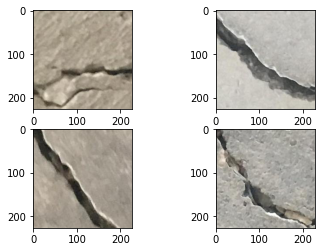

In [14]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Positive', random_images[3])))

*****************Random Images without Cracks**************************


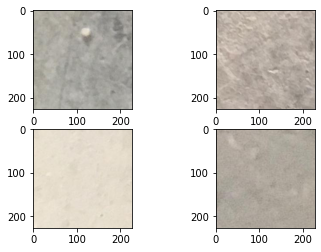

In [15]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join('/content/drive/MyDrive/colab_doan/Dataset/train', 'Negative', random_images[3])))

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# there are three channels in an RGB IMAGE.
# 1. red
# 2. green
# 3. blue

In [16]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [17]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  16046
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

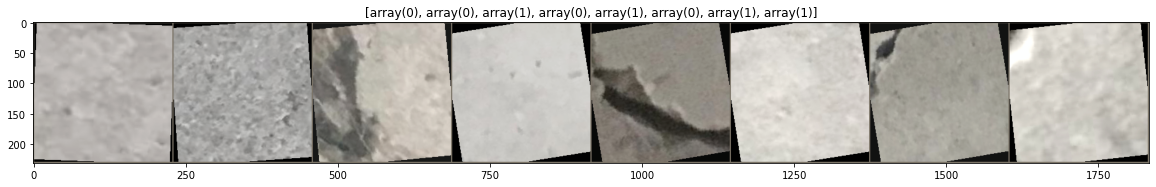

In [ ]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [ ]:
## Load pretrained model
# residual networks. These are a special type of neural networks in contrast to fully connected networks.
# this solves the problem of vanishing gradients.
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Linear layer is an alias for fully connected layer. 
# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:

# Define Optimizer and Loss Function
# learning rate decay. As we train the model, we can decide to change the learning rate dynamically.
# the schedular helps us in doing that.
#@ IN THE FIRST epoch, the learning rate was 0.1, then the learning rate in epoch 4 would be 0.01. 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
# training starts...
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
# Re-setting all of model parameters
                optimizer.zero_grad()
                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # this computes the class that the model belongs to...
                    _, preds = torch.max(outputs, 1)
                    # compute the loss here...
                    # we compute the difference between true label and the predicted output...
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # this is the back-propragation step. we 
                        # minimize our model loss and optimize model in this phase
                        optimizer.step()
                        # optimizer updates the model paramters...
                        

                # We want variables to hold the loss statistics
                # combine our model losses and compute the wrongly classified examples
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            # compute the loss and accuracy for each of our epoch
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2b1488f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2b1488f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.3105 Acc: 0.8726
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2b1488f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2b1488f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.2079 Acc: 0.9157

Epoch 1/5
----------
Iterating through data...
train Loss: 0.2139 Acc: 0.9192
Iterating through data...
val Loss: 0.1301 Acc: 0.9533

Epoch 2/5
----------
Iterating through data...
train Loss: 0.2017 Acc: 0.9244
Iterating through data...
val Loss: 0.1509 Acc: 0.9445

Epoch 3/5
----------
Iterating through data...
train Loss: 0.2002 Acc: 0.9229
Iterating through data...
val Loss: 0.1538 Acc: 0.9433

Epoch 4/5
----------
Iterating through data...
train Loss: 0.1976 Acc: 0.9252
Iterating through data...
val Loss: 0.1365 Acc: 0.9511

Epoch 5/5
----------
Iterating through data...
train Loss: 0.1920 Acc: 0.9273
Iterating through data...
val Loss: 0.1304 Acc: 0.9538

Training complete in 37m 57s
Best val Acc: 0.953815


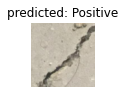

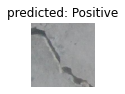

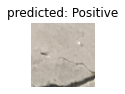

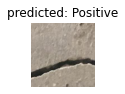

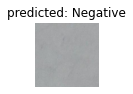

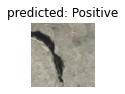

In [ ]:
base_model = train_model(resnet50, criterion, optimizer , exp_lr_scheduler,  num_epochs=6)
visualize_model(base_model)
plt.show()
torch.save(base_model, '/content/drive/MyDrive/colab_doan/model/model_resnet50')
# an epoch is the total time during which one training step completes. In other words, it is the total
# time that our model takes to process the input data once...

*********Load Model *********

In [ ]:
base_model = torch.load('/content/drive/MyDrive/colab_doan/model/resnet34')

In [ ]:
def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available(): # checks if we have a gpu available
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor)
        # this computes the probability of each classes.
        ps = torch.exp(out)
        # we choose the top class. That is, the class with highest probability
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                text ='P'
                color = (0,0, 255)
            else:
                text ='N'
                color = (0, 255, 0)
            cv2.putText(a, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image